This notebook shows how the scg signal is generated step by step and shows the derivation process of the function between x1,x2, y1, y2, H and S, D.

hr: 118 sp: 106 dp: 90


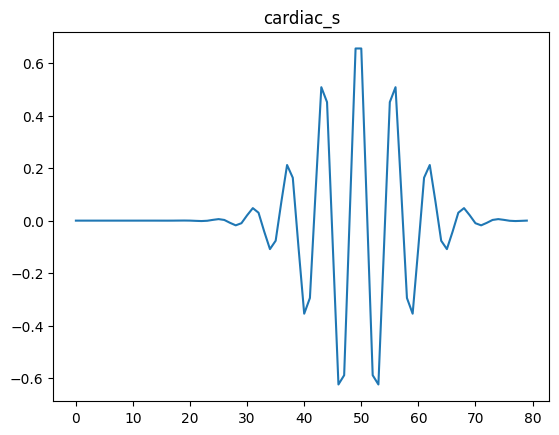

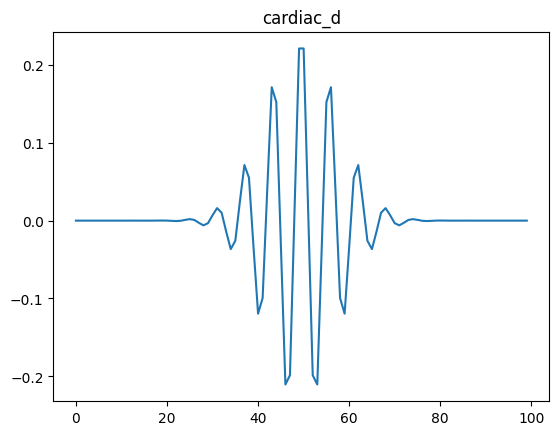

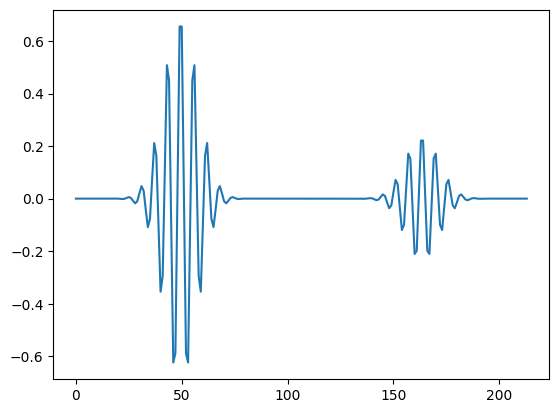

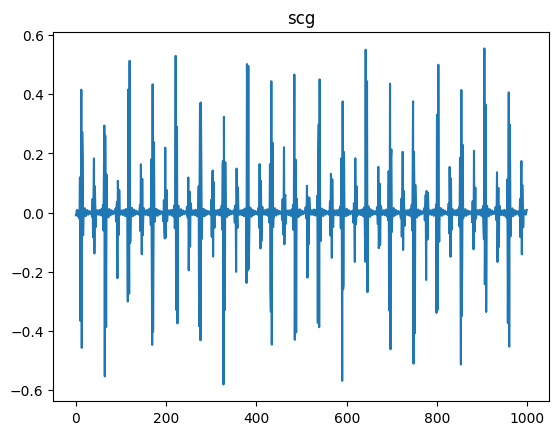

In [1]:
# Import necessary packages

import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.insert(1, './')
import datasim as nk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
from scipy import signal
from tqdm import tqdm
import math
import random
import numpy as np
import scipy
from datasim.signal import signal_distort, signal_resample
import matplotlib.pyplot as plt

# Set the parameters which are the parameters of the "scg_simulate" function 

duration = 10 # the signal lasts for 10 seconds
sampling_rate = 100
noise = 0.1
heart_rate = random.randint(50, 150)
respiratory_rate = random.randint(10, 30)
systolic = random.randint(90, 140)
diastolic = random.randint(60,100) # systolic

# Generate a protype of the cardiac period

print('hr:', heart_rate, 'sp:', systolic, 'dp:', diastolic)

ind = random.randint(3, 9) 
# ind = 30 # It should be a random value to make the wavelets different, but for convenient illustration, we set it fixed. 

cardiac_s = scipy.signal.wavelets.morlet(100,ind)
cardiac_d = scipy.signal.wavelets.morlet(100,ind)*0.3*diastolic/80 # change height to 0.3*diastolic/80

# resample them to 100 timestamp
cardiac_s = scipy.signal.resample(cardiac_s, 100)
cardiac_d = scipy.signal.resample(cardiac_d, 100)
cardiac_s = cardiac_s[0:80]

plt.title("cardiac_s")
plt.plot(cardiac_s)
plt.show()
plt.title("cardiac_d")
plt.plot(cardiac_d)
plt.show()

distance = 140-systolic 
zero_signal = np.zeros(distance)
cardiac = np.concatenate([cardiac_s, zero_signal, cardiac_d])

plt.plot(cardiac)
plt.show()

length = duration * sampling_rate # 1000

# Actually I don't understand the meaning of then next two lines. I think it won't affect anything, because we will do resampling at last. 
cardiac_length = int(100*sampling_rate/heart_rate)
cardiac = scipy.signal.resample(cardiac, cardiac_length)

# Caculate the number of beats in capture time period
num_heart_beats = int(duration * heart_rate / 60)

# Concatenate together the number of heart beats needed
scg = np.tile(cardiac, num_heart_beats)

# Resample to the needed length which is 1000 timestamps
scg = signal_resample(
    scg, sampling_rate=int(len(scg) / 10), desired_length=length, desired_sampling_rate=sampling_rate
)

plt.title("scg")
plt.plot(scg)
plt.show()

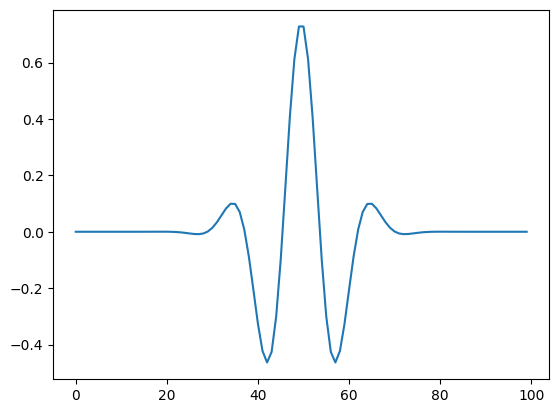

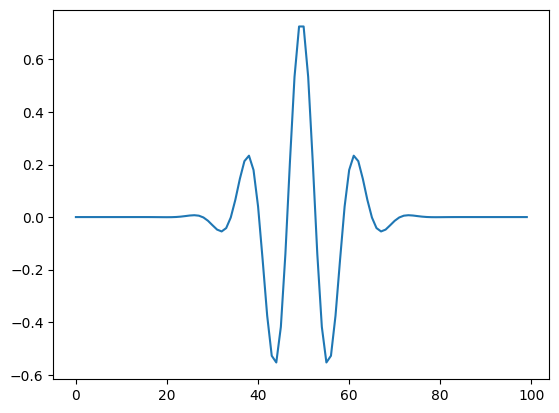

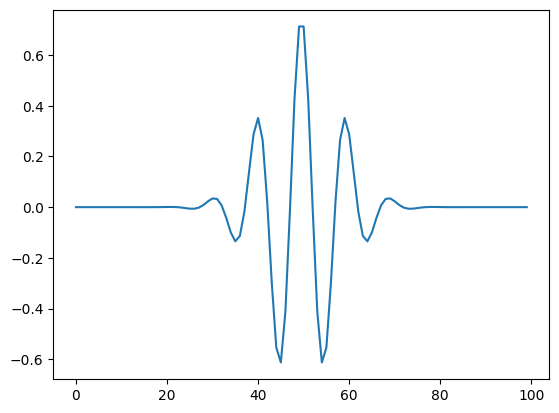

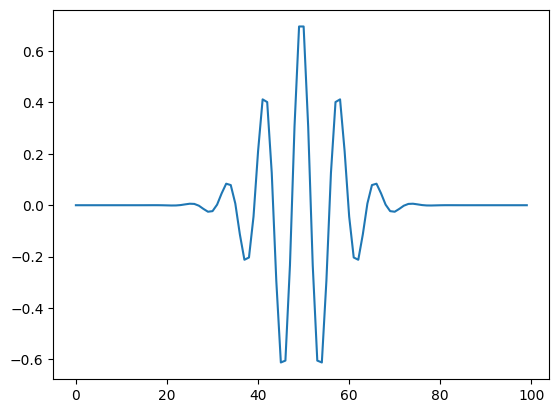

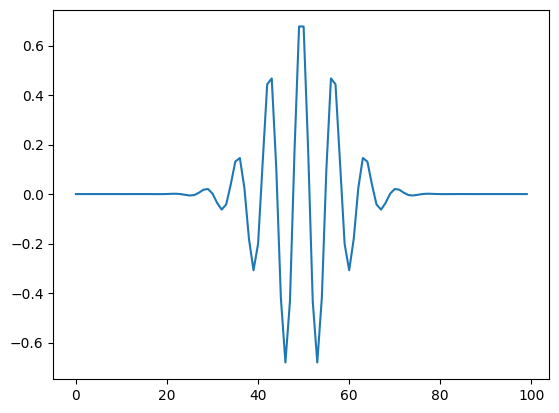

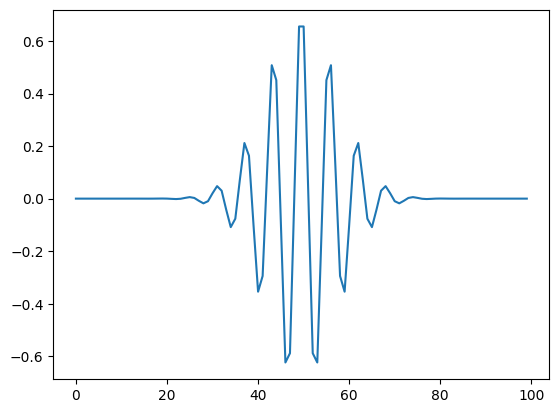

In [5]:
import scipy
import matplotlib.pyplot as plt

for i in range(3,9):
    tmp = scipy.signal.morlet(100,i).real
    plt.plot(tmp)
    plt.show()
#     for i in range(len(tmp)):
#         print(str(i+1) + ": " + str(tmp[i]))

The next step is to generate a protype of a cardiac period. It consists of a cardiac_s, a cardiac_d and a zero gap between the two cardiacs. We first use the daubechies wavelet to generate the cardiac_s, then we generate cardiac_d based on cardiac_s. Detailly, we change the height of cardiac_d to 0.3*daistolic/80 of cardiac_s. Then we resample all of them to 100 timestamp and use only the first 40 timestamp of cardiac_s. After that we generate a numpy of zeros whose lenght is 180-systolic. Finally we concatenate them together to get the a cardiac period whose lenght is (40 + 100 + 180 - systolic)

After getting the protype of a cardiac period. Next we should resample it to a suitable length based on the fs and heart rate. We hope the time of signal to be 10s and the fs is 100. So we should have (10*hr/60) cardiac periods in 10 seconds .

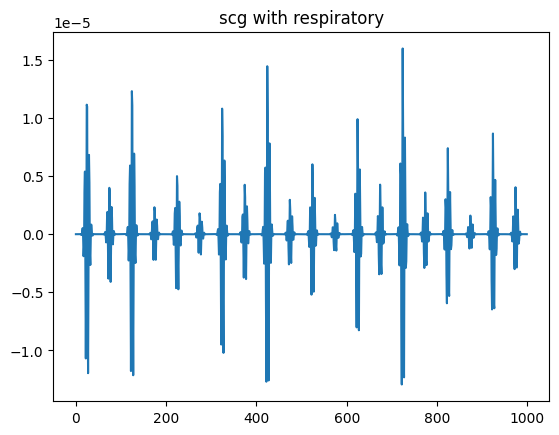

In [13]:
# Generate the respiratory signal. You can just view the respiratory as a kind of noise. It doesn't influence the S and D
num_points = duration * sampling_rate
x_space = np.linspace(0,1,num_points)
seg_fre = respiratory_rate / (60/duration)
seg_amp = max(scg) * 0.00001
rr_component = seg_amp * np.sin(2 * np.pi * seg_fre * x_space)

#  Add respiratory signal to the scg signal
scg *= (rr_component + 2 * seg_amp)

plt.title("scg with respiratory")
plt.plot(scg)
plt.show()

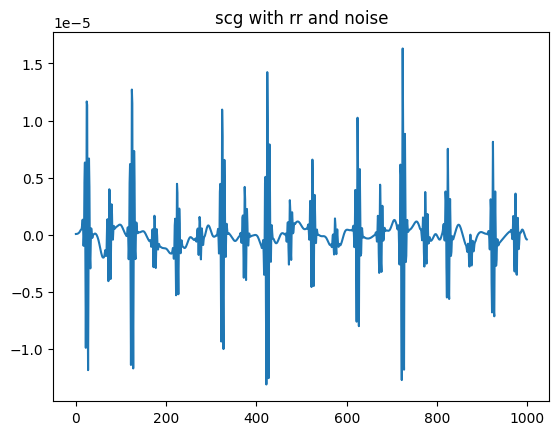

In [14]:
# Add laplace noise to scg to get the final scg
random_state=None
scg = signal_distort(
    scg,
    sampling_rate=sampling_rate,
    noise_amplitude=noise,
    noise_frequency=[5, 10, 100],
    noise_shape="laplace",
    random_state=random_state,
    silent=True,
)
plt.title("scg with rr and noise")
plt.plot(scg)
plt.show()

According to the above process. We can get the relationship between x1 (the horizontal location of cardiac_s), x2 (the horizontal location of cardiac_d), y1 (the vertical location of cardiac_s peak), y2 (the vertical location of cardiac_d peak), H (heart rate) and S, D.
7
For D, it is obviously that the relationship between y1, y2 and D is:
$$
y2 = 0.3y1\frac{D}{80}
$$
However, due to the respiratory signal, the vertical location of the peaks will change a lot, so generally we should use a algorithm to remove the respiratory signal.

For S, it is about the horizontal location of peaks, so the respiratory signal won't influence it. The resampling process will influence it slightly.

**Before the resampling**, in a cardiac period, the relationship of x1, x2 and S should be:
$$
x2-x1 = 220 - S
$$
and the length of a cardiac period is (40 + 100 + 180 - S), that is (320 - S). The resampling won't change the proportion of x2-x1 to cardiac period. So **after the resampling**, we can get such equation which shows the proportion of x2-x1 (they are the location after resampling) to cardiac period is same:
$$
\frac{220-S}{320-S}=\frac{x2-x1}{100*60/hr}
$$
where the left part is before resampling and the right part is after resampling.

So do some transformation to the equation above, we can get the relationship between x1, x2, H and S, which is:
$$
S = 320 + \frac{600000}{(x2-x1) * hr - 6000}
$$